# RNN USE
I denne notebooken tar jeg i bruk den modellen jeg har lagd tidligere

In [281]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens
from lib.create_dataset import create_dataset

In [277]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_15_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma15_derivert'] = [stock.open_15_sma[i] / stock.open_15_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_15_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        stocks.append(stock)
    
    return stocks

def prepare_evaluate_trade(prediction):
    # Setter indeks til hver for å få riktig.. Litt tungvindt
    where_are_NaNs = np.isnan(prediction) #Byttet NaN til 1
    prediction[where_are_NaNs] = 1
    
    dict_pred = {}
    
    for i, pred in enumerate(prediction):
        for j, v in enumerate(pred):
            if i+j not in dict_pred:
                dict_pred[i+j] = [v]
            else:
                dict_pred[i+j].append(v)
    
    
    df_pred = pd.DataFrame(columns=['tid','verdier','avg'])
    df_pred.tid = list(dict_pred.keys())
    df_pred.verdier = list(dict_pred.values())
    df_pred.avg = [sum(l)/len(l) for l in list(dict_pred.values())]
    
    return df_pred


def evaluate_trade(data, df_pred, prediciton, look_forward):
    
    fig, ax1 = plt.subplots()
    for i,v in enumerate(prediciton):
        ax1.plot(range(i+30, i+30+len(v)), v, color='red')
        
    p1, = ax1.plot(range(30, len(df_pred.avg)+30), df_pred.avg, color='black', label='avg_pred')
    
    ax2 = ax1.twinx()
    p2, = ax2.plot(data.open, color='blue', label='true_price')
    ax2.set_ylabel('True price')
    ax2.yaxis.label.set_color('blue')
    
    # If df_pred.avg is big enough then buy
    forslag = ['0_selg']*20
    bytteix = pd.DataFrame(columns=['kjøp', 'selg', 'pris_kjøp', 'pris_salg', 'gevinst'])
    bytteix_buy = []
    bytteix_sell = []
    bytteswitch = True
    for ix,i in enumerate(df_pred.avg):
        if i > 1:
            forslag.append('1_kjøp')
            if bytteswitch:
                bytteix_buy.append(ix+20)
                bytteswitch = False
                
        else:
            forslag.append('0_selg')
            if not bytteswitch:
                bytteix_sell.append(ix+20)
                bytteswitch = True
    
    bytteix.kjøp = bytteix_buy
    bytteix.selg = bytteix_sell
    
    gevinst = []
    pris_kjøp = []
    pris_salg = []
    for i, row in bytteix.iterrows():
        buy = data.open[row.kjøp]
        sell = data.open[row.selg]
        gevinst.append(sell/buy)
        pris_kjøp.append(data.open[row.kjøp])
        pris_salg.append(data.open[row.selg])
    
    bytteix.gevinst = gevinst
    bytteix.pris_kjøp = pris_kjøp
    bytteix.pris_salg = pris_salg
        
    
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    p3, = ax3.plot(forslag, color='green')
    ax3.set_ylabel('forslag axes')
    ax3.yaxis.label.set_color('green')
    
    lines = [p1, p2]
    plt.legend(lines, [l.get_label() for l in lines])
    
    plt.show()
    
    print(bytteix)
    

    
def add_data(word):
    ordet = 'data/' + word
    return ordet


In [278]:
filer = list(map(add_data, os.listdir('data/')))[50:55] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [283]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset().create(
                                  one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)
    sanne.append(sann)

In [6]:
model = keras.models.load_model('models/rnn_model.h5')

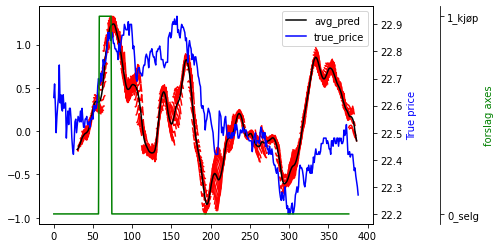

   kjøp  selg  pris_kjøp  pris_salg   gevinst
0    58    74      22.68      22.87  1.008377


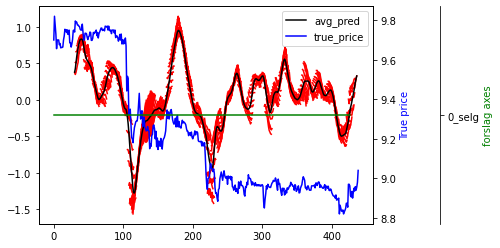

Empty DataFrame
Columns: [kjøp, selg, pris_kjøp, pris_salg, gevinst]
Index: []


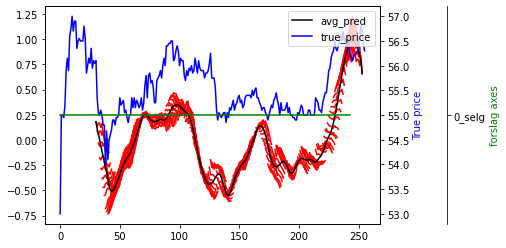

Empty DataFrame
Columns: [kjøp, selg, pris_kjøp, pris_salg, gevinst]
Index: []


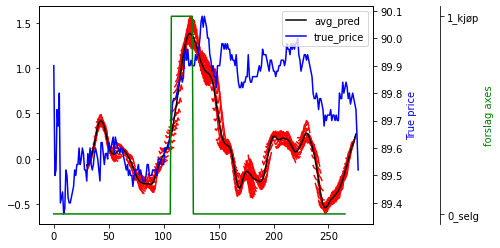

   kjøp  selg  pris_kjøp  pris_salg  gevinst
0   107   127       89.7       89.9  1.00223


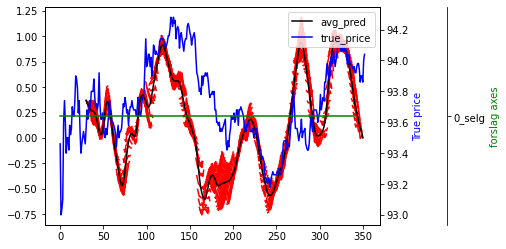

Empty DataFrame
Columns: [kjøp, selg, pris_kjøp, pris_salg, gevinst]
Index: []


In [284]:
for i,stockdata in enumerate(data):
    prediciton = model.predict(dataxes[i])
    df_pred = prepare_evaluate_trade(prediciton)
    evaluate_trade(stockdata, df_pred, prediciton, look_forward)

In [224]:
df_pred

,tid,verdier,avg
0,0,[0.020621946],0.020622
1,1,"[-0.026052017, 0.020630259]",-0.002711
2,2,"[0.044839945, -0.022079226, -0.00922976]",0.004510
3,3,"[0.055913787, 0.048681762, -0.048904564, -0.06...",-0.003486
4,4,"[-0.0020739879, 0.059355784, 0.019778218, -0.1...",-0.021156
...,...,...,...
399,399,"[-0.09311583, -0.09163511, -0.13157076, -0.159...",-0.141347
400,400,"[-0.13458154, -0.1465865, -0.21132563, -0.2471...",-0.184923
401,401,"[-0.1808438, -0.22672324, -0.2931144]",-0.233560
402,402,"[-0.24940243, -0.30677682]",-0.278090


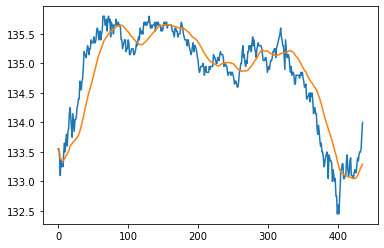

In [69]:
plt.plot(data[0].open)
plt.plot(data[0].open_30_sma)

In [143]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,133.55,133.55,133.55,133.55,77319,77319,NaN,NaN,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
1,9:1,133.55,133.55,133.55,133.55,13845,13845,133.55,0.00,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
2,9:2,133.40,133.40,133.40,133.40,29772,29772,133.55,-0.15,0.000000,...,133.500000,-0.004651,-0.001906,-0.002745,133.500000,133.500000,0.000000,0.999626,0.999626,0.998877
3,9:3,133.10,133.10,133.10,133.10,14807,14807,133.40,-0.30,0.000000,...,133.400000,-0.017484,-0.007183,-0.010301,133.400000,133.400000,0.000000,0.999251,0.999251,0.997751
4,9:4,133.35,133.35,133.35,133.35,13958,13958,133.10,0.25,0.594707,...,133.390000,-0.014142,-0.009253,-0.004888,133.390000,133.390000,0.000000,0.999925,0.999925,1.001878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,16:16,133.50,133.50,133.50,133.50,12738,12738,133.45,0.05,1.274000,...,133.243750,0.060187,0.021415,0.038772,133.195000,133.250000,0.068750,1.000263,1.000175,1.000375
432,16:17,133.50,133.50,133.50,133.50,33641,33641,133.50,0.00,1.274000,...,133.265625,0.071448,0.031421,0.040027,133.223333,133.260000,0.084375,1.000213,1.000075,1.000000
433,16:18,133.55,133.55,133.55,133.55,12709,12709,133.50,0.05,1.336942,...,133.278125,0.083446,0.041826,0.041619,133.245000,133.270000,0.121875,1.000163,1.000075,1.000375
434,16:19,133.80,133.80,133.80,133.80,17495,17495,133.55,0.25,1.668213,...,133.303125,0.111837,0.055828,0.056009,133.265000,133.316667,0.178125,1.000150,1.000350,1.001872
